# Imports

In [28]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from random import choice, randint
from heapq import heappop, heappush

# Maze Generator.
- 1. Create main path: This method directly generates a guaranteed path from (0, 0) to (size-1, size-1) by moving either down or right. It avoids the use of any search algorithm, ensuring a direct path to the goal without backtracking.

- 2. Add random paths: After establishing the main path, this method adds some random paths around the grid to increase maze complexity. It ensures these additional paths do not obstruct the direct path from start to end.

- 3. Maze Initialization: The maze grid is initialized with walls (' | '), and paths are carved as we progress in create_main_path and add_random_paths.

In [29]:
class Maze:
    '''
    Class to generate and store the maze structure as a 2D grid with a guaranteed path from start to end.
    '''
    def __init__(self, size):
        self.size = size
        self.grid = np.full((size, size), ' | ')  # Initialize grid with walls
        self.create_main_path()  # Ensure a path from start to end
        self.add_random_paths()  # Add additional paths for complexity
        self.grid[0, 0] = ' S '  # Start point
        self.grid[size - 1, size - 1] = ' E '  # End point

    def create_main_path(self):
        '''
        Creates a guaranteed path from start (0, 0) to end (size-1, size-1).
        '''
        x, y = 0, 0
        self.grid[x, y] = ' # '  # Start point is a path

        while (x, y) != (self.size - 1, self.size - 1):
            # Randomly choose a direction to move towards the end point
            directions = []
            if x < self.size - 1:  # Can move down
                directions.append((x + 1, y))
            if y < self.size - 1:  # Can move right
                directions.append((x, y + 1))

            # Pick a random direction that brings us closer to the end
            x, y = choice(directions)
            self.grid[x, y] = ' # '  # Carve path

    def add_random_paths(self):
        '''
        Adds random paths in the maze without blocking the main path from start to end.
        '''
        for _ in range(self.size * self.size // 3):  # Add paths to about 1/3 of the maze cells
            x, y = randint(0, self.size - 1), randint(0, self.size - 1)
            
            # Only carve a path if it's currently a wall and not the start/end
            if self.grid[x, y] == ' | ' and (x, y) != (0, 0) and (x, y) != (self.size - 1, self.size - 1):
                self.grid[x, y] = ' # '

    def is_within_bounds(self, x, y):
        '''
        Checks if the coordinates are within maze bounds.
        '''
        return 0 <= x < self.size and 0 <= y < self.size

    def is_path(self, x, y):
        '''
        Checks if the cell is a path (accessible) cell.
        '''
        return self.grid[x, y] == ' # ' or self.grid[x, y] == ' E '

    def display(self):
        '''
        Prints the maze for debugging purposes.
        '''
        for row in self.grid:
            print(''.join(row))

In [30]:
# Display a smple of the generated maze.
m = Maze(20)
m.display()

 S  #  |  |  #  |  |  #  |  |  |  #  #  #  |  |  |  |  |  | 
 #  #  #  #  #  #  #  #  |  |  |  |  |  |  #  |  #  |  #  # 
 |  |  |  |  |  #  #  #  |  #  |  #  #  |  |  |  |  #  #  | 
 |  |  |  |  #  |  |  #  |  |  |  |  #  |  |  |  |  |  |  | 
 |  #  #  #  |  |  #  #  #  #  #  |  |  |  |  |  |  #  |  | 
 |  |  |  |  |  |  |  |  #  #  #  |  #  #  |  #  #  |  |  # 
 |  #  |  |  |  |  |  |  |  |  #  #  |  |  #  |  #  |  |  | 
 |  |  |  |  #  |  |  #  |  |  |  #  #  |  |  |  |  |  |  # 
 #  |  |  |  #  |  |  |  |  |  |  #  #  |  |  |  |  |  #  # 
 #  |  |  #  #  |  #  #  #  |  |  #  #  #  #  |  |  |  |  # 
 |  |  |  #  |  |  |  #  #  |  |  #  |  |  #  |  #  |  |  | 
 |  |  #  #  |  |  |  |  |  #  |  |  |  |  #  #  |  |  |  | 
 |  |  #  #  |  |  |  |  |  |  #  #  #  |  #  #  #  #  |  # 
 #  |  #  #  |  |  #  #  |  |  |  #  |  |  |  #  #  #  #  # 
 |  #  #  |  #  #  #  #  |  #  #  #  |  |  |  |  |  |  |  # 
 #  |  |  #  |  |  |  |  |  |  |  |  |  #  |  #  |  |  |  # 
 |  |  |  |  |  |  |  | 

# The Main Maze Solver Structure.
- This is the main or parent class that will assit in solving the maze.

In [31]:
class MazeSolver:
    '''
    Base class for maze solvers. Contains common methods like solve and get neighbors with setup.
    '''
    def __init__(self, maze):
        self.maze = maze
        self.path = []
        self.visited = set()

    def solve(self):
        '''
        Solves the maze and returns the path.
        '''
        raise NotImplementedError("This method should be implemented by subclasses.")

    def get_neighbors(self, x, y):
        '''
        Returns the neighboring cells (up, down, left, right).
        '''
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        neighbors = [(x + dx, y + dy) for dx, dy in directions]
        
        return [(nx, ny) for nx, ny in neighbors if self.maze.is_within_bounds(nx, ny) and self.maze.is_path(nx, ny)]

    def reconstruct_path(self, came_from, end):
        '''
        Reconstructs the path from end to start.
        '''
        path = []
        current = end
        while current in came_from:
            path.append(current)
            current = came_from[current]
            
        path.reverse()
        
        return path

# Sub-classes for each algorithm.
- Classes to implement each algorithm to solve a given maze. The algorithms include:
    - 1. Depth-First Search
    - 2. Breadth-First Search
    - 3. Greedy-Depth-First Search
    - 4. Greedy-breadth-first-search
    - 5. A* Search
    - 6. Dijkstra's algorithm
    - 7. Johnson algorithm.

In [32]:
class DFSSolver(MazeSolver):
    '''
    Solver using Depth-First Search.
    '''
    def solve(self):
        '''
        Depth-First Search to find a path to the end.
        '''
        stack = [(0, 0)]
        came_from = { (0, 0): None }
        while stack:
            x, y = stack.pop()
            if (x, y) == (self.maze.size - 1, self.maze.size - 1): # End point
                return self.reconstruct_path(came_from, (x, y))
                
            for nx, ny in self.get_neighbors(x, y):
                if (nx, ny) not in came_from:
                    stack.append((nx, ny))
                    came_from[(nx, ny)] = (x, y)
        return []
        

class BFSSolver(MazeSolver):
    '''
    Solver using Breadth-First Search.
    '''
    
    def solve(self):
        '''
        Breadth-First Search to find the shortest path.
        '''
        queue = [(0, 0)]
        came_from = { (0, 0): None }
        
        while queue:
            x, y = queue.pop(0)
            
            if (x, y) == (self.maze.size - 1, self.maze.size - 1):
                return self.reconstruct_path(came_from, (x, y))
                
            for nx, ny in self.get_neighbors(x, y):
                if (nx, ny) not in came_from:
                    queue.append((nx, ny))
                    came_from[(nx, ny)] = (x, y)
        return []

    def reconstruct_path(self, came_from, end):
        '''
        Reconstructs path from end to start using BFS came_from.
        '''
        
        path = []
        current = end
        
        while current:
            path.append(current)
            current = came_from[current]
        path.reverse()
        
        return path


class GBFSSolver(MazeSolver):
    '''
    Solver using Greedy Best-First Search.
    '''
    def solve(self):
        '''
        Greedy Best-First Search prioritizing nodes closest to the end.
        '''
        end = (self.maze.size - 1, self.maze.size - 1)
        queue = [(self.heuristic(0, 0, end), (0, 0))]
        came_from = { (0, 0): None }
        
        while queue:
            _, (x, y) = heappop(queue)
            if (x, y) == end:
                return self.reconstruct_path(came_from, end)
                
            for nx, ny in self.get_neighbors(x, y):
                if (nx, ny) not in came_from:
                    heappush(queue, (self.heuristic(nx, ny, end), (nx, ny)))
                    came_from[(nx, ny)] = (x, y)
        return []

    def heuristic(self, x, y, end):
        '''
        Heuristic function for Greedy BFS (Manhattan distance).
        '''
        return abs(x - end[0]) + abs(y - end[1])


class GDFSSolver(MazeSolver):
    '''
    Solver using Greedy Depth-First Search.
    '''
    def solve(self):
        '''
        Greedy Depth-First Search prioritizing nodes closest to the end.
        '''
        end = (self.maze.size - 1, self.maze.size - 1)
        stack = [(self.heuristic(0, 0, end), (0, 0))]
        came_from = { (0, 0): None }
        while stack:
            _, (x, y) = stack.pop()
            if (x, y) == end:
                return self.reconstruct_path(came_from, end)
            for nx, ny in self.get_neighbors(x, y):
                if (nx, ny) not in came_from:
                    stack.append((self.heuristic(nx, ny, end), (nx, ny)))
                    came_from[(nx, ny)] = (x, y)
        return []

    def heuristic(self, x, y, end):
        '''
        Heuristic function for Greedy DFS (Manhattan distance).
        '''
        return abs(x - end[0]) + abs(y - end[1])


class AStarSolver(MazeSolver):
    '''
    Solver using A* algorithm.
    '''
    def solve(self):
        '''
        A* Search with combined heuristic and cost function.
        '''
        end = (self.maze.size - 1, self.maze.size - 1)
        open_set = [(self.heuristic(0, 0, end), 0, (0, 0))]
        came_from = { (0, 0): None }
        g_score = { (0, 0): 0 }

        while open_set:
            _, current_g, (x, y) = heappop(open_set)
            if (x, y) == end:
                return self.reconstruct_path(came_from, end)
                
            for nx, ny in self.get_neighbors(x, y):
                tentative_g = current_g + 1
                if (nx, ny) not in g_score or tentative_g < g_score[(nx, ny)]:
                    came_from[(nx, ny)] = (x, y)
                    g_score[(nx, ny)] = tentative_g
                    f_score = tentative_g + self.heuristic(nx, ny, end)
                    heappush(open_set, (f_score, tentative_g, (nx, ny)))
                    
        return []

    def heuristic(self, x, y, end):
        '''
        Heuristic function for A* (Manhattan distance).
        '''
        return abs(x - end[0]) + abs(y - end[1])


class DijkstraSolver(MazeSolver):
    '''
    Solver using Dijkstra's algorithm.
    '''
    def solve(self):
        '''
        Dijkstra's algorithm to find the shortest path based on distance.
        '''
        end = (self.maze.size - 1, self.maze.size - 1)
        priority_queue = [(0, (0, 0))]
        came_from = { (0, 0): None }
        cost = { (0, 0): 0 }

        while priority_queue:
            current_cost, (x, y) = heappop(priority_queue)
            if (x, y) == end:
                return self.reconstruct_path(came_from, end)
                
            for nx, ny in self.get_neighbors(x, y):
                new_cost = current_cost + 1
                if (nx, ny) not in cost or new_cost < cost[(nx, ny)]:
                    cost[(nx, ny)] = new_cost
                    priority_queue.append((new_cost, (nx, ny)))
                    came_from[(nx, ny)] = (x, y)
        return []

class JohnsonSolver(MazeSolver):
    '''
    Solver using Johnson's algorithm (primarily for all-pairs shortest paths).
    '''
    def solve(self):
        '''
        Johnson's algorithm applied as single-source shortest path by treating other cells as unreachable.
        '''
        # Since Johnson's algorithm is primarily designed for all-pairs shortest paths,
        # here we'll simulate it by finding shortest paths as in Dijkstra's with multiple sources.
        return DijkstraSolver(self.maze).solve()


# Maze Visualizer.
- MazeVisualizer class: This class is essential for the visualization and drawing of each algorithm’s path.

In [33]:
class MazeVisualizer:
    '''
    Class for visualizing and drawing the maze and solving algorithms.
    '''
    def __init__(self, maze, path=None):
        self.maze = maze
        self.path = path if path else []

    def draw_maze(self):
        '''
        Draws the maze with paths, walls, start, and end.
        '''
        size = self.maze.size
        image = Image.new('RGB', (size * 10, size * 10), 'white')
        draw = ImageDraw.Draw(image)
        for i in range(size):
            for j in range(size):
                color = 'black' if self.maze.grid[i, j] == '|' else 'white'
                draw.rectangle([(j * 10, i * 10), ((j + 1) * 10 - 1, (i + 1) * 10 - 1)], fill=color)
        draw.rectangle([(0, 0), (9, 9)], fill='green')  # Start
        draw.rectangle([(size * 10 - 10, size * 10 - 10), (size * 10 - 1, size * 10 - 1)], fill='red')  # End
        
        return image

    def draw_solution_path(self, algorithm_name):
        '''
        Draws the solution path over the maze.
        '''
        image = self.draw_maze()
        draw = ImageDraw.Draw(image)
        for x, y in self.path:
            draw.rectangle([(y * 10, x * 10), ((y + 1) * 10 - 1, (x + 1) * 10 - 1)], fill='blue')
        
        plt.title(f"Solution using {algorithm_name}")
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Simulation and Timing
- Run simulation: This function will be responsible for running and handling simulations on each algorithm.
- Time_solve: This function is responsible for the timing of each algorithm and return time taken in seconds during runtime. 

In [34]:
def run_simulation(maze_size, num_simulations):
    '''Runs the simulation for all solvers on a generated maze.'''
    results = {}
    for _ in tqdm(range(num_simulations), desc="Simulating Solvers"):
        maze = Maze(maze_size)
        
        solvers = {'DFS': DFSSolver, 'BFS': BFSSolver, 'Greedy BFS': GBFSSolver, 'Greedy DFS': GDFSSolver, 
                   'A*': AStarSolver, 'Dijkstra': DijkstraSolver, 'Johnson': JohnsonSolver}
        
        for name, solver_class in solvers.items():
            path, duration = time_solver(solver_class, maze)
            if name not in results:
                results[name] = []
            results[name].append((path, duration))

    return results
        
def time_solver(solver_class, maze):
    '''
    Times the solving process for a given solver class and maze.
    '''
    solver = solver_class(maze)
    start_time = time.time()
    path = solver.solve()
    end_time = time.time()
    
    return path, end_time - start_time

# Performance and Plotting.
- Plot performance: A function to plot the performance of an algorithm based on the time it has taken to find the complete path.
- Plot path: A function to plot and show how the algorith has travased the maze.

In [43]:
def plot_performance(results):
    '''
    Plots the performance of each solver based on time taken.
    '''
    names = list(results.keys())
    times = [np.mean([duration for _, duration in results[name]]) for name in names]
    
    plt.figure(figsize=(10, 5))
    plt.barh(names, times, color='skyblue')
    plt.ylabel('Average Time (seconds)')
    plt.title('Algorithms Performance Comparison.')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_paths(results):
    '''
    Plots the paths found by each solver in separate subplots.
    '''
    num_solvers = len(results)
    fig, ax = plt.subplots(1, num_solvers, figsize=(5 * num_solvers, 5))
    fig.suptitle('Paths of Each Solver', fontsize=16)

    # Ensure `ax` is an iterable even if there's only one subplot
    if num_solvers == 1:
        ax = [ax]

    for idx, (name, paths) in enumerate(results.items()):
        size = results[name][0][0][-1][0] + 1  # Assuming paths have at least one point
        image = Image.new('RGB', (size * 10, size * 10), 'white')
        draw = ImageDraw.Draw(image)

        # Draw the maze background
        maze = Maze(size)  # Generate a sample maze for visualization
        
        for i in range(size):
            for j in range(size):
                color = 'black' if maze.grid[i, j] == '|' else 'white'
                draw.rectangle([(j * 10, i * 10), ((j + 1) * 10 - 1, (i + 1) * 10 - 1)], fill=color)
        draw.rectangle([(0, 0), (9, 9)], fill='green')  # Start
        draw.rectangle([(size * 10 - 10, size * 10 - 10), (size * 10 - 1, size * 10 - 1)], fill='red')  # End

        # Draw the solution path for the current solver
        path = paths[0][0]  # Get the path from the first simulation for each solver
        for x, y in path:
            draw.rectangle([(y * 10, x * 10), ((y + 1) * 10 - 1, (x + 1) * 10 - 1)], fill='blue')

        # Display the image in the subplot
        ax[idx].imshow(image)
        ax[idx].set_title(name)
        ax[idx].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    plt.show()

# Driver Code.

Simulating Solvers: 100%|██████████| 20000/20000 [02:05<00:00, 159.65it/s]


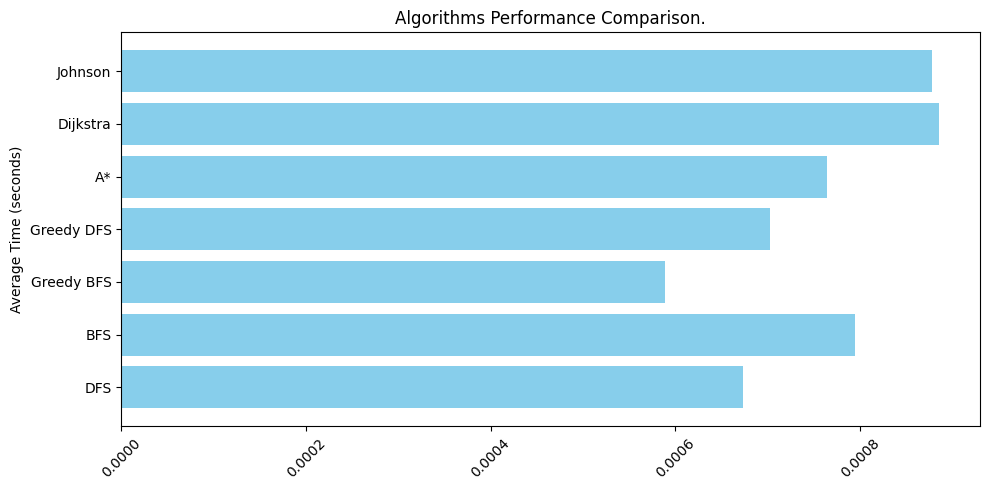

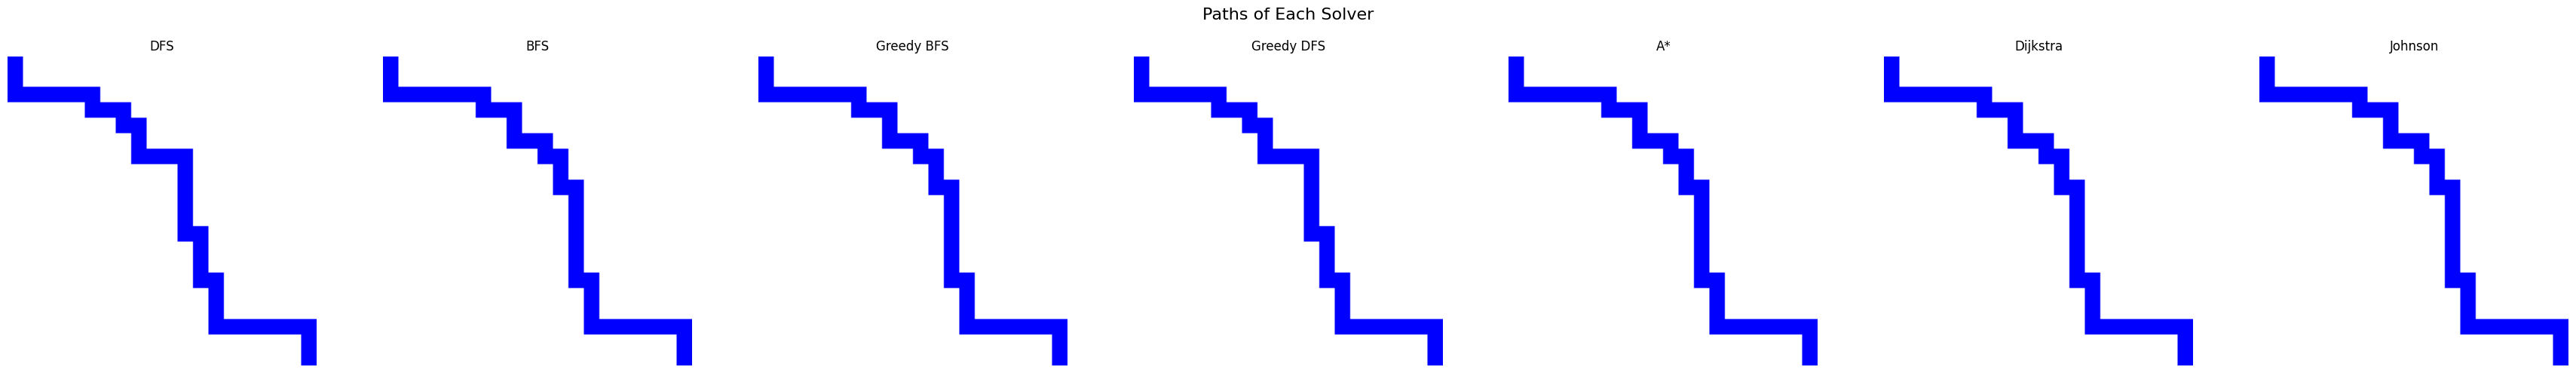

In [46]:
def main():
    num_simulations = 20000  # Number of simulations to run
    maze_size = 20  # Size of the maze
    results = run_simulation(maze_size, num_simulations)
    
    plot_performance(results)
    plot_paths(results)

if __name__ == '__main__':
    main()

In [ ]:
num_simulations = 20000  # Number of simulations to run
maze_size = 20  # Size of the maze
results = run_simulation(maze_size, num_simulations)

img1 = plot_performance(results)
img2 = plot_paths(results)

plt.savefig('img1.png', img1)
plt.savefig('img2.png', img2)